# Input

In [1]:
image_path = '/content/drive/My Drive/data/ip/camvid/data/images/0006R0_f02190.png'

# Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image
from matplotlib import cm
import cv2
import argparse
import numpy as np

# Loading Unet Model for Image Segmentation

In [3]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
learn = load_learner(path='/content/drive/My Drive/data/ip/camvid/models')

# Image Segmentation using loaded model and storing overlay image of mask on input

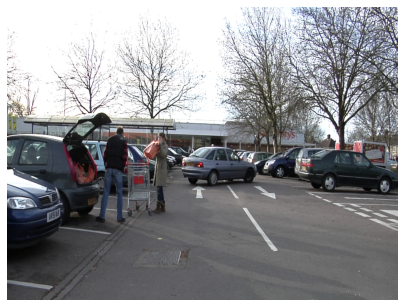

In [4]:

mask_path = '/content/drive/My Drive/data/ip/camvid/test/mask.png'
img = open_image(image_path)
img.show(figsize=(7,7))

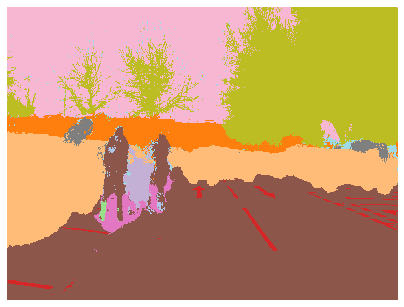

In [5]:
prediction=learn.predict(img)
prediction[0].show(figsize=(7,7), alpha=1)

In [6]:
img_arr = prediction[0].data.numpy()
arr = img_arr[0]/32
im = Image.fromarray(np.uint8(cm.rainbow(arr)*255))
im.save(mask_path)

In [7]:
background = cv2.imread(image_path)
overlay = cv2.imread(mask_path)

added_image = cv2.addWeighted(background,0.8,overlay,0.4,0)

cv2.imwrite(mask_path, added_image)

True

# Obejct Detection and drawing bounding boxes on overlay image

In [8]:
config_path = '/content/drive/My Drive/data/ip/camvid/yolo/yolov3.cfg'
weights_path = '/content/drive/My Drive/data/ip/camvid/yolo/yolov3.weights'
classes_path = '/content/drive/My Drive/data/ip/camvid/yolo/yolov3.txt'

def get_output_layers(net):

    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


image = cv2.imread(image_path)

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet(weights_path, config_path)

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
mask = cv2.imread(mask_path)
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(mask, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

# Output

In [10]:
plt.imsave('/content/drive/My Drive/data/ip/camvid/test/output.png', mask)

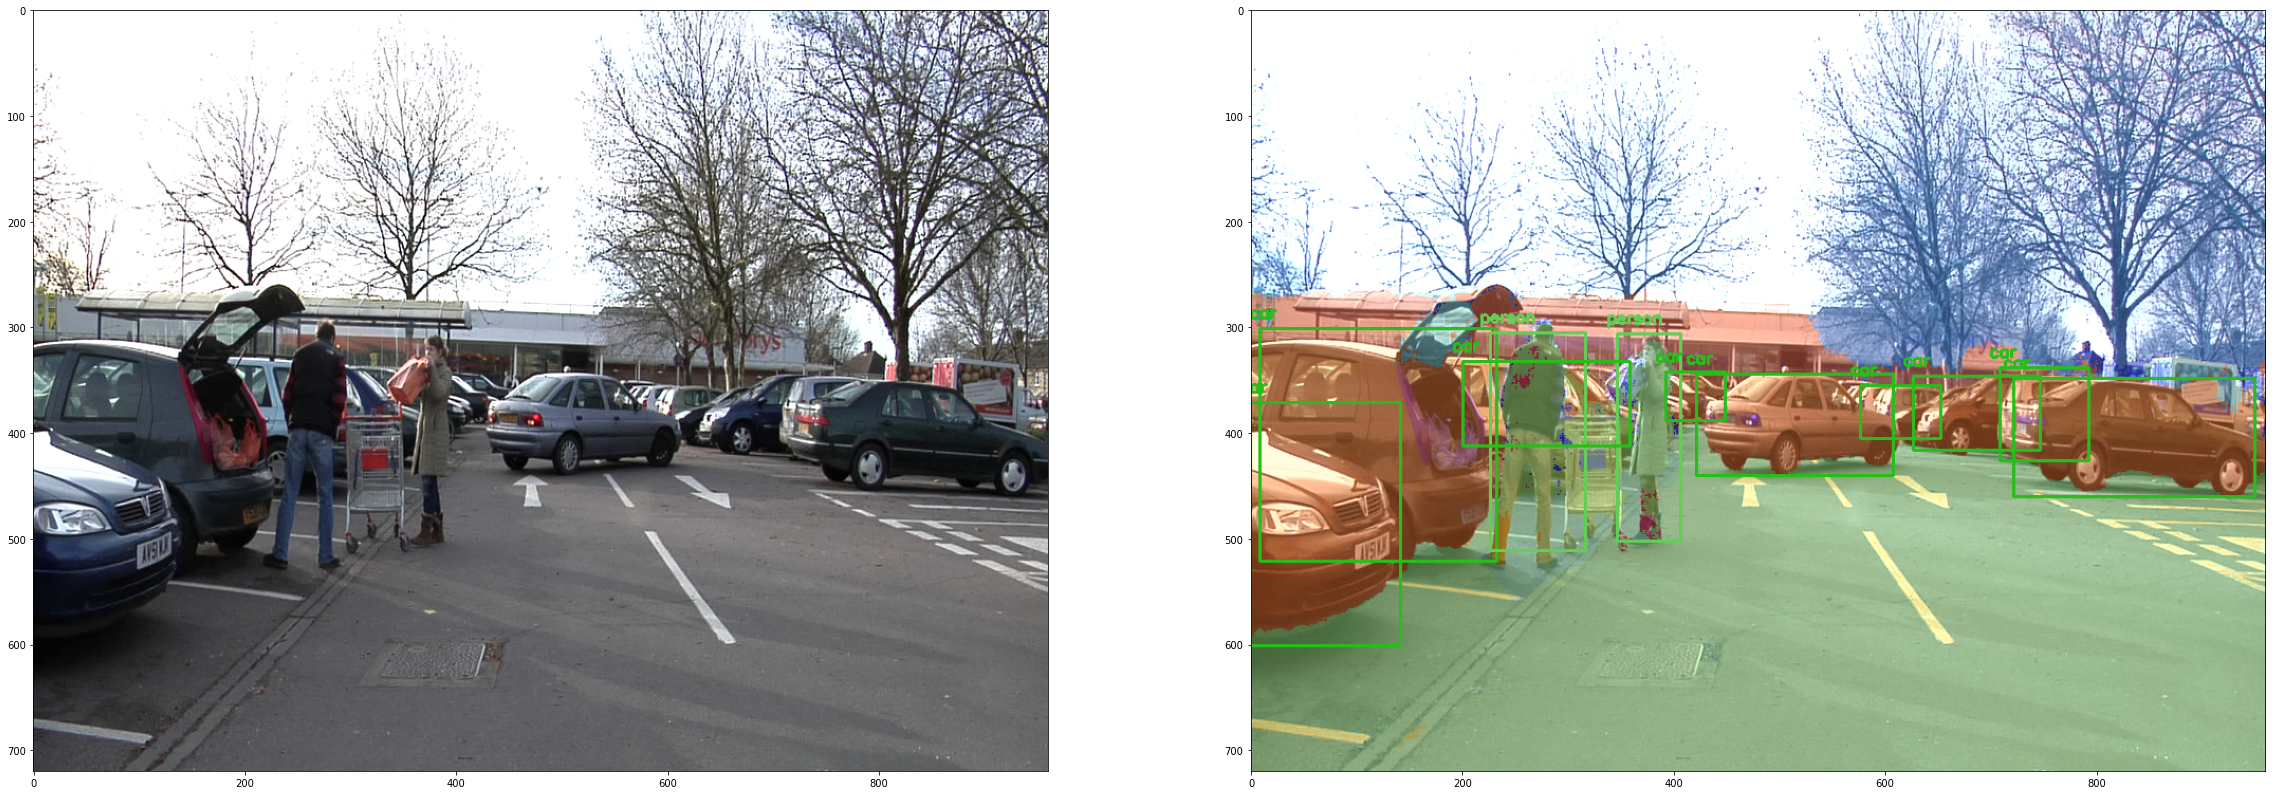

In [9]:
plt.figure(figsize=(40,80))
plt.subplot(1,2,1)
img = plt.imread(image_path)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()